In [1]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Dropout
import matplotlib.pyplot as plt
%matplotlib inline

# Initialization
batch_size = 60
image_row = 32
image_col = 32
image_filter = 3
max_epoch = 10

input_shape = (batch_size, image_row, image_col, image_filter)

# Locate oder of the classes of interest 
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

order = unpickle('./meta')[b'coarse_label_names']
allowed_classes = [order.index(b'flowers'),
                   order.index(b'trees'),
                   order.index(b'large_man-made_outdoor_things'),
                   order.index(b'people'),
                   order.index(b'vehicles_1'),
                   order.index(b'vehicles_2')]
new_order = [0,0,1,2,3,4]

update_table = tf.lookup.StaticHashTable(
    tf.lookup.KeyValueTensorInitializer(allowed_classes,
                                        new_order),
                                        -1)

# Load CIFAR-10 data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data(label_mode = 'coarse')

# Normalize 
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train, y_test = tf.cast(y_train, tf.int32), tf.cast(y_test, tf.int32)


# Filter helper function
def predicate(_, y):
    return tf.greater(tf.reduce_sum(tf.cast(tf.equal(y, allowed_classes), tf.uint8)), 0)

def reorder(x, y):
    return (x, update_table.lookup(y))

# Filter, shuffle and batch
train_ds = (tf.data.Dataset.from_tensor_slices((x_train, y_train))
            .filter(predicate)
            .map(reorder)
            .shuffle(1000)
            .batch(batch_size))
test_ds = (tf.data.Dataset.from_tensor_slices((x_test, y_test))
            .filter(predicate)
            .map(reorder)
            .shuffle(1000)
            .batch(batch_size))

In [2]:
class CNN(Model):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = Conv2D(10, kernel_size = (5, 5), strides = (1, 1), padding = 'valid', activation = 'relu', input_shape = input_shape)
        self.maxpool1 = MaxPool2D((2, 2))
        self.conv2 = Conv2D(30, kernel_size = (3, 3), activation = 'relu')
        self.maxpool2 = MaxPool2D((2, 2))
        self.flatten = Flatten()
        self.d1 = Dense(128, activation = 'relu')
        self.d2 = Dense(len(set(new_order)))
        self.dropout = Dropout(0.2)

    def call(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.flatten(x)
        x = self.d1(x)
        x = self.d2(x)
        return self.dropout(x)

model = CNN()

In [3]:
loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean()
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

test_loss = tf.keras.metrics.Mean()
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()


@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        pred = model(images, training = True)
        loss = loss_obj(labels, pred)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    train_loss(loss)
    train_accuracy(labels, pred)

@tf.function
def test_step(images, labels):
    pred = model(images, training = False)
    loss = loss_obj(labels, pred)
    test_loss(loss)
    test_accuracy(labels, pred)
    
train_history = {'loss': [], 'accuracy': []}
test_history = {'loss': [], 'accuracy': []}

for epoch in range(1, max_epoch+1):
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    
    for images, labels in train_ds:
        train_step(images, labels)
    
    for images, labels in test_ds:
        test_step(images, labels)
        
    train_history['loss'].append(train_loss.result())
    train_history['accuracy'].append(train_accuracy.result())
    test_history['loss'].append(test_loss.result())
    test_history['accuracy'].append(test_accuracy.result())
        
    template = "=> Epoch {:2d} Loss {:.2f} Accuracy {:.2f}\n(Test) Loss {:.4f} Accracy {:.4f}"
    print(template.format(epoch,
                          train_history['loss'][-1],
                          train_history['accuracy'][-1],
                          test_history['loss'][-1],
                          test_history['accuracy'][-1]))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

=> Epoch  1 Loss 1.26 Accuracy 0.48
(Test) Loss 0.9850 Accracy 0.6323
=> Epoch  2 Loss 1.00 Accuracy 0.61
(Test) Loss 0.8940 Accracy 0.6647
=> Epoch  3 Loss 0.92 Accuracy 0.65
(Test) Loss 0.8269 Accracy 0.6963
=> Epoch  4 Loss 0.87 Accuracy 0.67
(Test) Loss 0.8030 Accracy 0.7117
=> Epoch  5 Loss 0.83 Accuracy 0.69
(Test) Loss 0.7232 Accracy 0.7343
=> Epoch  6 Loss 0.79 Accuracy 0.70
(Test) Loss 0.7115 Accracy 0.7403
=> Epoch  7 Loss 0.75 Accuracy 0.72
(Test) Loss 0.7170 Accracy 0.7420
=> Epoch  8 Loss 0

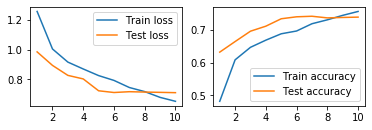

In [4]:
plt.figure()
plt.subplot(221)
plt.plot(range(1, max_epoch + 1), train_history['loss'], label = 'Train loss')
plt.plot(range(1, max_epoch + 1), test_history['loss'], label = 'Test loss')
plt.legend()

plt.subplot(222)
plt.plot(range(1, max_epoch + 1), train_history['accuracy'], label = 'Train accuracy')
plt.plot(range(1, max_epoch + 1), test_history['accuracy'], label = 'Test accuracy')
plt.legend()

In [8]:
id_to_class = ['其他', '建筑和户外设施', '人', 'I类车辆', 'II类车辆']

def predict(img):
    return tf.argmax(model.predict(img[tf.newaxis, ...]), -1).numpy()[0]

train_lst = list(train_ds.as_numpy_iterator())

Xs = train_lst[2][0][:10]
ys = [y[0] for y in train_lst[2][1][:10]]

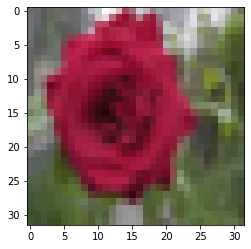

预测:  其他
实际:  其他 



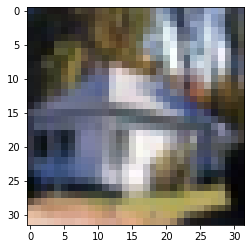

预测:  建筑和户外设施
实际:  建筑和户外设施 



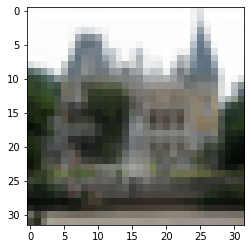

预测:  建筑和户外设施
实际:  建筑和户外设施 



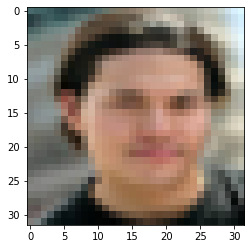

预测:  人
实际:  人 



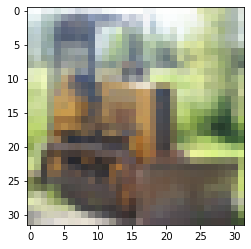

预测:  II类车辆
实际:  II类车辆 



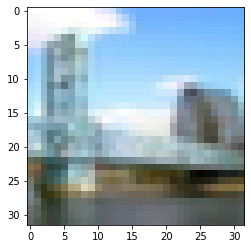

预测:  建筑和户外设施
实际:  建筑和户外设施 



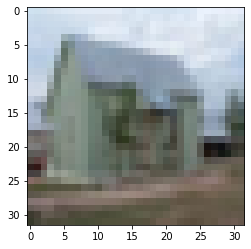

预测:  建筑和户外设施
实际:  建筑和户外设施 



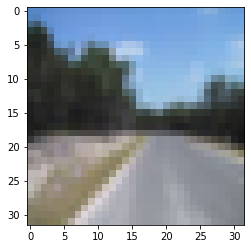

预测:  建筑和户外设施
实际:  建筑和户外设施 



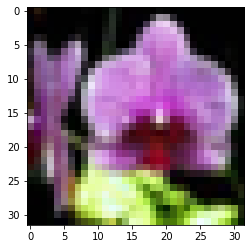

预测:  其他
实际:  其他 



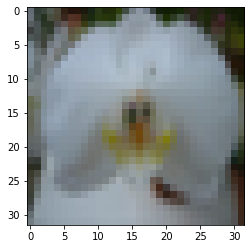

预测:  其他
实际:  其他 

100.0  %


In [9]:
plt.figure()
success_count = 0

for x, y in zip(Xs, ys):
    plt.imshow(x)
    plt.pause(0.01)
    plt.close()
    print('预测: ', id_to_class[predict(x)])
    print('实际: ', id_to_class[y], '\n')
    if predict(x) == y:
        success_count += 1
        
print(success_count / len(Xs) * 100, ' %')